### [디지털 금융의 이해] 3주차 수업 (2023-03-17)

***

> < 3주차 수업 학습 목표 >
> - 결측치 대체가 잘 되었는지를 확인하려면 ?
> - 여러가지 결측치 대체 방법들

***

### > 필요한 모듈 임포트
 - 설치 권한이 없을 시, '관리자로 실행'하여 다시 재설치 진행

In [119]:
from IPython.display import Image
import yfinance as yf    
import pandas as pd
import numpy as np       
import matplotlib.pyplot as plt  
from sklearn.metrics import mean_squared_error    
from scipy import interpolate   

pd.options.display.float_format = '{:.8f}'.format

### > 시계열 데이터 불러오기 : 야후 파이낸스의 LG 화학 주가 데이터
 - 종목 'LG 화학'의 종가 (Adj Close)만 사용

In [35]:
df_lg = yf.download('051910.KS', start = '2021-01-01', end = '2022-12-31')
df_lg = df_lg.loc[:, ['Adj Close']]
display(df_lg)

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2021-01-04,858232.93750000
2021-01-05,862094.56250000
2021-01-06,859198.37500000
2021-01-07,928706.56250000
2021-01-08,964426.06250000
...,...
2022-12-23,600286.62500000
2022-12-26,608159.25000000
2022-12-27,618000.00000000


In [36]:
df_lg.reset_index(drop = False, inplace = True) 

### > 결측치 생성 데이터 불러오기
 - 결측치가 존재하는 이유
  - 주가 데이터의 경우, 공휴일(장이 닫는 날)
  - 매출 데이터의 경우, 식당의 휴무일
  - 데이터 수집 시기에 네트워크 이슈 혹은 센서 에러 등의 이유로 수집 불가한 경우
  - 단순 누락된 경우

In [37]:
dat_dir = "C:/Users/hallym/Desktop/[2023-1] 디지털 금융의 이해/3주차/"
df_NaN = pd.read_csv(dat_dir + "dat_NaN.csv", sep = ",")

In [38]:
#df_NaN.isnull().sum()

### > 결측치 생성 전후의 그래프 그려보기

- 날짜 관련 타입 {Timestamp}으로 변환 (pandas 모듈에서 생성) 
- str값으로 넣어주어야 함

In [39]:
df_NaN['Date'] = df_NaN['Date'].astype(str)
df_NaN['Date'] = pd.to_datetime(df_NaN['Date'], format = '%Y-%m')

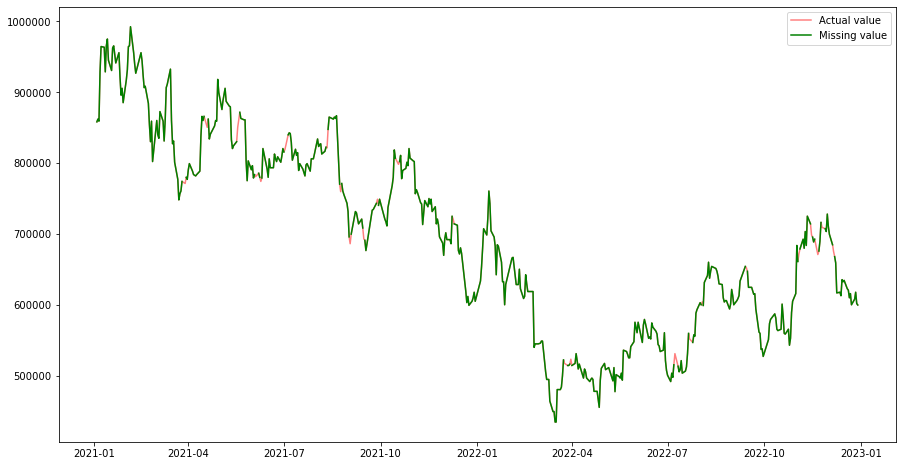

In [40]:
plt.figure(figsize=[15, 8])
plt.ticklabel_format(axis='y', style='plain')  

plt.plot(df_lg['Date'], df_lg['Adj Close'], label = 'Actual value', c = "red", linestyle = "solid", alpha = 0.5)
plt.plot(df_NaN['Date'], df_NaN['Adj Close'], label = 'Missing value', c = "green", linestyle ="solid")
plt.legend()

### > 결측치 대체가 잘 되었는지를 확인하려면 ?

- rMSE (root Mean Squared error)을 이용해 각 방법들의 성능을 측정함

$ RMSE = \sqrt{ \frac{1}{n} \sum_{t=0}^n (X_t - \hat{X_t})^2}$

In [41]:
# MSE = mean_squared_error(Actual_value, Pred_value)
# RMSE = round(np.sqrt(MSE), 4)

### > 여러가지 결측치 대체 방법들
 - 시계열 데이터가 아닌 경우 : 일반적으로 평균값/중앙값/최빈값 혹은 회귀 대체, 결측치 제거 등
 - 시간의 흐름에 따라 데이터의 평균과 분산이 변하기 때문에 이러한 특징을 잘 반영하는 방법론을 활용해야함

#### 1) 결측치의 이전 값(previous value, 직전 값)으로 채워 넣는 Forward Fill 방식
 - 연산 상 부담이 적고, 가장 간단한 방법
 - 추정 오차가 클 수 있음
 - 원데이터의 성향을 띄는 경향이 강함

In [42]:
df_NaN['Adj Close_forwardfill'] = df_NaN['Adj Close'].fillna(method = "ffill")

In [43]:
forwardfill_RMSE = round(np.sqrt(mean_squared_error(df_lg['Adj Close'], df_NaN['Adj Close_forwardfill'])), 3)
forwardfill_RMSE

2326.62

In [44]:
nan_idx = df_NaN[np.isnan(df_NaN['Adj Close']) == True]

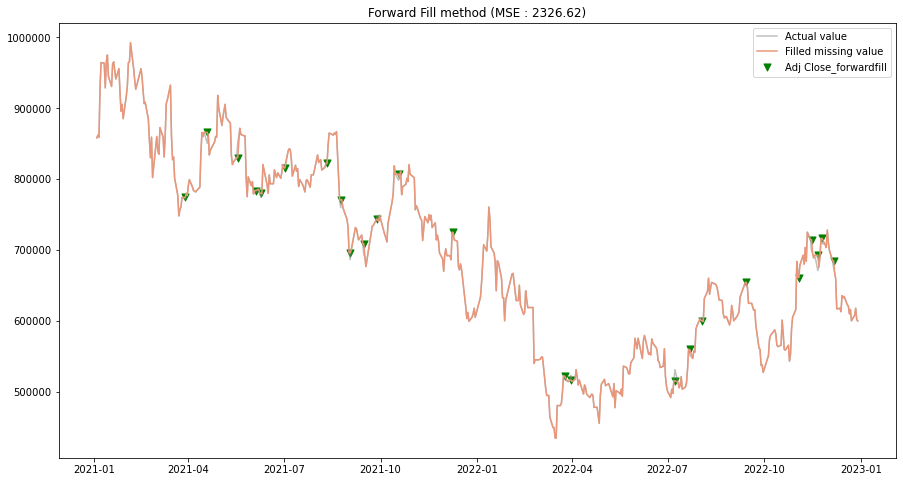

In [53]:
plt.figure(figsize=[15, 8])
plt.ticklabel_format(axis='y', style='plain')  

plt.plot(df_lg['Date'], df_lg['Adj Close'], label = 'Actual value', c = "gray", linestyle ="solid", alpha = 0.5)
plt.plot(df_NaN['Date'], df_NaN['Adj Close_forwardfill'], label = 'Filled missing value', c = "darksalmon", linestyle = "solid")
plt.scatter(data = df_NaN[np.isnan(df_NaN['Adj Close']) == True], x = 'Date', y = 'Adj Close_forwardfill', 
            marker = 'v', s = 50, color = 'green')
plt.title("Forward Fill method (MSE : {})".format(forwardfill_RMSE))
plt.legend()

#### 2) 결측치의 다음 값(next value, 직후 값)으로 채워 넣는 Backward Fill 방식
 - 연산 상 부담이 적고, 가장 간단한 방법
 - 추정 오차가 클 수 있음

In [46]:
df_NaN['Adj Close_backwardfill'] = df_NaN['Adj Close'].fillna(method = "bfill")

In [47]:
backwardfill_RMSE = round(np.sqrt(mean_squared_error(df_lg['Adj Close'], df_NaN['Adj Close_backwardfill'])), 3)
backwardfill_RMSE

2410.899

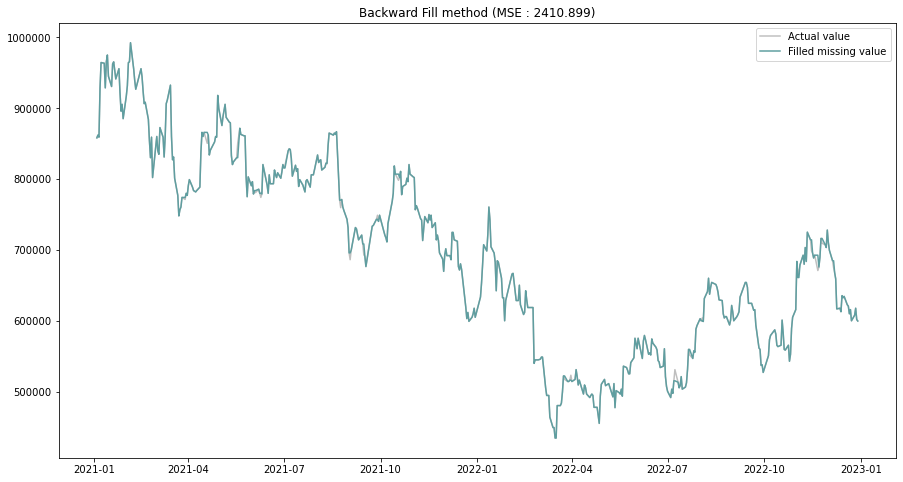

In [52]:
plt.figure(figsize=[15, 8])
plt.ticklabel_format(axis='y', style='plain')  

plt.plot(df_lg['Date'], df_lg['Adj Close'], label = 'Actual value', c = "gray", linestyle ="solid", alpha = 0.5)
plt.plot(df_NaN['Date'], df_NaN['Adj Close_forwardfill'], label = 'Filled missing value', c = "cadetblue", linestyle = "solid")
plt.title("Backward Fill method (MSE : {})".format(backwardfill_RMSE))
plt.legend()

#### 3) 최근접 이웃 보간(Interpolation of nearest neighbors)
 - 직전 n (혹은 직후 n) 의 평균 혹은 중앙값으로 결측치를 대체
 - 결측치 전후의 패턴이 변화하는 구간인 경우, 이전 값의 평균으로 대체하게 되면 실제값과 큰 차이가 발생 <br>
  예> 주가의 상승 혹은 하락하는 구간에 결측치가 존재하는 경우 <br>
  => 이런 경우에 선형 보간법(Linear interpolation)을 이용

In [85]:
def knn_mean(ts_dat, n) :
    arr_ts = np.copy(ts_dat)   
    
    for i, value in enumerate(ts_dat) :
        if np.isnan(value) :
            #print(i)
            
            n_by_2 = np.ceil(n/2)
            
            ts_near = np.concatenate([ts_dat[int(i-n_by_2):i], ts_dat[i:int(i+n_by_2)]], axis = 0)  
            arr_ts[i] = np.nanmean(ts_near) 
            
    return arr_ts

In [88]:
df_NaN['Adj Close_KNN_mean'] = knn_mean(df_NaN['Adj Close'].values, 10) 

In [89]:
KNN_mean_RMSE = round(np.sqrt(mean_squared_error(df_lg['Adj Close'], df_NaN['Adj Close_KNN_mean'])), 3)
KNN_mean_RMSE

4295.645

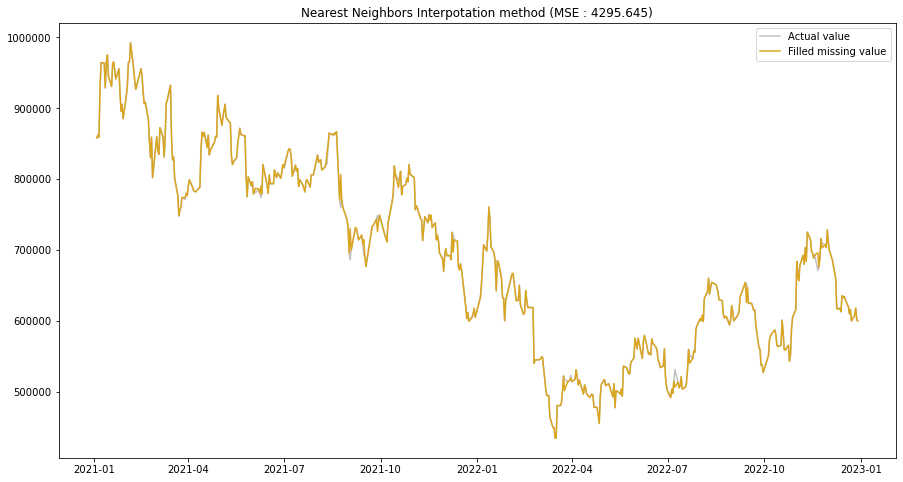

In [114]:
plt.figure(figsize=[15, 8])
plt.ticklabel_format(axis='y', style='plain') 

plt.plot(df_lg['Date'], df_lg['Adj Close'], label = 'Actual value', c = "gray", linestyle ="solid", alpha = 0.5)
plt.plot(df_NaN['Date'], df_NaN['Adj Close_KNN_mean'], label = 'Filled missing value', c = "goldenrod", linestyle = "solid")
plt.title("Nearest Neighbors Interpotation method (MSE : {})".format(KNN_mean_RMSE))
plt.legend()

#### 4) 선형 보간법(Linear Interpolation)
 - 대표적인 보간법
 - 선형 보간법은 결측치가 주변 데이터에 대해 선형적인 일관성을 갖게 되므로, 상황에 따라 원데이터와 근사하게 나오는 경우가 많음"
 - 결측치가 너무 많을 경우에는 사용하기 힘든 대체법
 - 일반적인 데이터라면, 결측치가 아닌 데이터로도 결측치를 어느정도 설명할 수 있으나, 시계열 데이터는 시간에 따라 변하므로 힘듦

In [117]:
df_NaN['Adj Close_linear'] = df_NaN['Adj Close'].interpolate(method ='linear')

In [118]:
Linear_RMSE = round(np.sqrt(mean_squared_error(df_lg['Adj Close'], df_NaN['Adj Close_linear'])), 3)
Linear_RMSE

1747.75

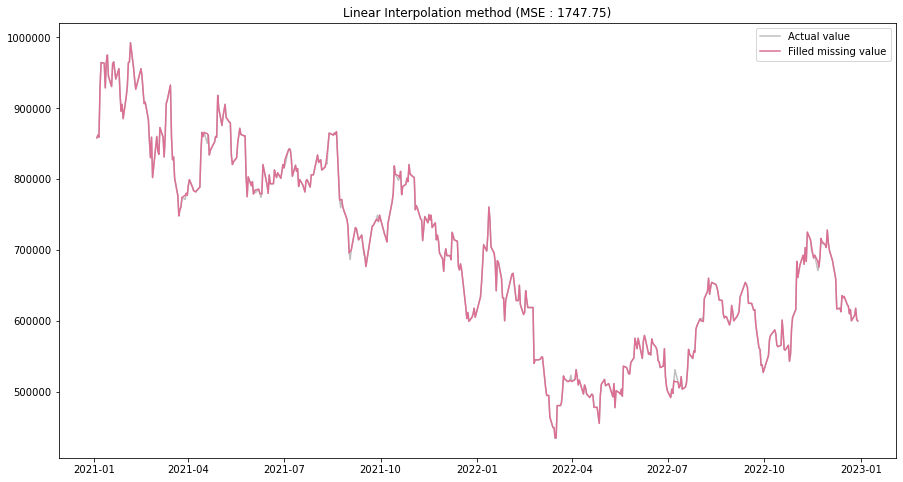

In [113]:
plt.figure(figsize=[15, 8])
plt.ticklabel_format(axis='y', style='plain') 

plt.plot(df_lg['Date'], df_lg['Adj Close'], label = 'Actual value', c = "gray", linestyle ="solid", alpha = 0.5)
plt.plot(df_NaN['Date'], df_NaN['Adj Close_linear'], label = 'Filled missing value', c = "palevioletred", linestyle = "solid")
plt.title("Linear Interpolation method (MSE : {})".format(Linear_RMSE))
plt.legend()

#### 5) 그 외

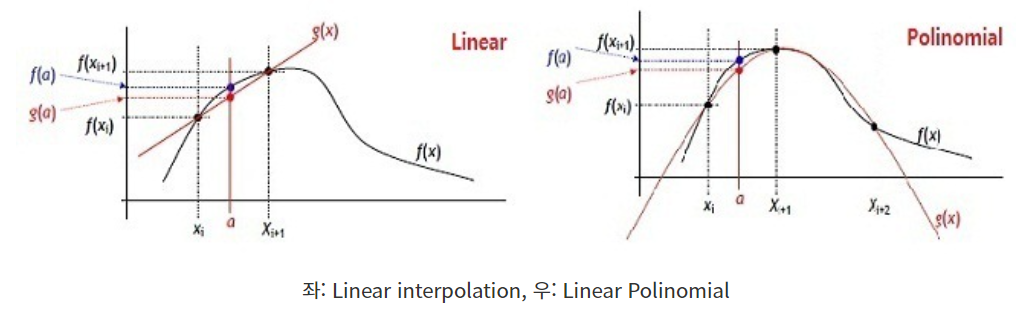

In [108]:
Image("C:/Users/hallym/Desktop/[2023-1] 디지털 금융의 이해/3주차/fig/그 외 보간법의 종류.png")